In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.optim as optim
from torchviz import make_dot, make_dot_from_trace
from torch.utils.tensorboard import SummaryWriter 
# Please install the required library using command pip install torch/<library_name>

#### Disclaimer: Please feel free to rewrite the entire on your own if you find any issues, Thanks

In [2]:
torch.manual_seed(100) # To reproduce results freeze a seed

In [3]:
# Disc: Please feel rewrite the entire on your own if you find any issues
# Set up the compute device: CPU or Cuda, if you have multiple GPUs, you can choose one using <cuda:0> or
# <cuda:1>
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [29]:
# Disc: Please feel rewrite the entire on your own if you find any issues
# Generate training samples
K=500 # number of samples
X1=np.linspace(-1,1,K)  
X2=np.linspace(-1,1,K)

# Generate test samples
T=50
X1_test=np.linspace(-2,-1,T)
X2_test=np.linspace(1,2,T)  
# Create input feature vector
Features=[[X1[i],X2[i]]for i in range(K)]
Features_test=[[X1_test[i],X2_test[i]]for i in range(T)]
# Target Quadratic function
Q_function=[[X1[i]**2 +X2[i]**2] for i in range(K)]

# Adding noise to training samples
mu, sigma = 0, np.sqrt(0.01)
noise=np.random.normal(mu,sigma,np.shape(Q_function))

Q_function=Q_function+noise

Q_function_test=[[X1_test[i]**2 +X2_test[i]**2] for i in range(T)]

# It's good practice to make sure all the inputs (later weights and biases) have same data type.
Output=torch.as_tensor(Q_function,dtype=torch.float32,device=device)
Input=torch.as_tensor(Features,dtype=torch.float32,device=device)

# Test inputs and outputs
Output_test=torch.as_tensor(Q_function_test,dtype=torch.float32,device=device)
Input_test=torch.as_tensor(Features_test,dtype=torch.float32,device=device)

Model_Training_Performance=[]
Model_Parameters=[]
Model_Testing_Performance=[]

# more details on type casting please look at 
# https://pytorch.org/docs/stable/tensor_attributes.html

Text(0.5, 0.92, 'Noisy training samples')

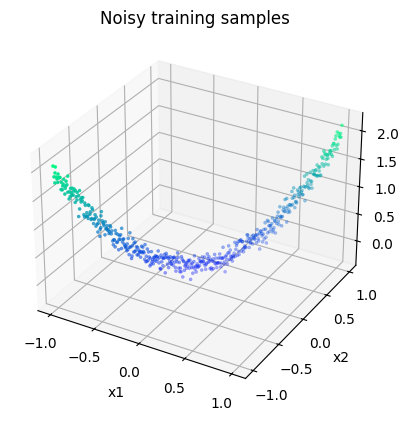

In [30]:
# Disc: Please feel rewrite the entire on your own if you find any issues



# Visualize function on training samples
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',marker='.', linewidth=.25)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.grid()
ax.set_title('Noisy training samples')

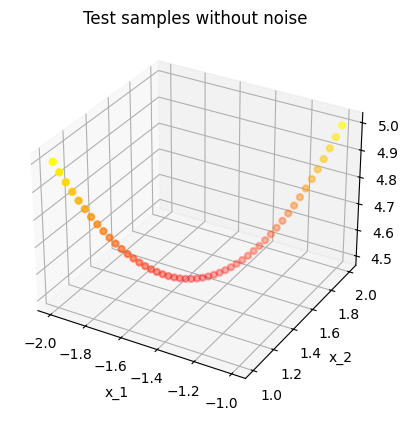

In [6]:
# Visualize function on testing samples
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1_test, X2_test, Q_function_test, c=Q_function_test, cmap='autumn', linewidth=1.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('f')
ax.set_title('Test samples without noise')
ax.grid()

In [7]:
# Create a network with no hidden layers

class simpleNetwork(nn.Module):
    def __init__(self) -> None:
         super().__init__() # 
         self.flatten = nn.Flatten()
         self.fc1=nn.Linear(2,1) # Input dimension 2,  Output  1
         self.fc2=nn.Linear(1,1) # Dimensions of output layer 1 and input layer 2 of next fully connected layer
                                 # must match
    def forward(self,f_hat):
        f_hat = F.relu(self.fc1(f_hat))
        f_hat = self.fc2(f_hat)
        return f_hat

simpleNet=simpleNetwork().to(device)



In [8]:
print(simpleNet)
# Prints the network
# Please use tensorboard to visualize structure of neural network of your choice

simpleNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
)


In [9]:
# Now, add a hidden layer
# Again, start with  input layer, add a hidden layer and finally a output layer
class smallNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.fc1=nn.Linear(2,5) # We have input with 2 features
                                # Input expands to 5 output features
                                # 
        self.fc2=nn.Linear(5,5) # Output and input of next fully connected layer must match
        self.fc3=nn.Linear(5,1) # Output of fc2 and input of fc3 must match
    def forward(self,f_hat):
        f_hat = F.relu(self.fc1(f_hat))
        f_hat = F.relu(self.fc2(f_hat))
        f_hat = self.fc3(f_hat)
        return f_hat

In [10]:
tinyNet=smallNetwork().to(device) # Instance of class small network


In [11]:
print(tinyNet) # Summarizes neural network

smallNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)


In [12]:
# Let's do a forward pass
Input[0]  # take first input sample and do a forward pass 
print("Sample Input", Input[0])
Output_net=simpleNet(Input[0])
print("Network output",Output_net,"Function value", Output[0])

Sample Input tensor([-1.0000, -0.9920], device='cuda:0')
Network output tensor([0.3530], device='cuda:0', grad_fn=<ViewBackward0>) Function value tensor([2.0590], device='cuda:0')


In [13]:
# Next step is to define a loss metric
# There are several loss functions to choose from

loss_metric=nn.MSELoss() # Since we want to approximate a function 
                           # Mean squared error is a good choice
# Choice of loss function depends on the problem at hand
# Other forms of loss functions include
# Cross Entropy: nn.CrossEntropyLoss
# KL divergence: nn.KLDivLoss
# L1 loss: nn.L1Loss 
# Negative log likelihood: nn.NLLLoss 
# More details at https://pytorch.org/docs/stable/nn.html#loss-functions

In [14]:
# Calculate loss
loss=loss_metric(Output_net,Output[0])
print("Mean Square Loss",loss)

Mean Square Loss tensor(2.9103, device='cuda:0', grad_fn=<MseLossBackward0>)


So far we have defined
1. Function to be approximated by a neural network
2. A neural network architecture
3. A loss metric


In [15]:
# Before we go ahead and initiate training process, let's look at number of parameters in our
# neural network 

list(tinyNet.parameters()) # prints neural network parameters at each layer.

[Parameter containing:
 tensor([[ 0.3591, -0.3356],
         [-0.6465, -0.4129],
         [-0.5402, -0.5350],
         [ 0.3332,  0.2995],
         [ 0.4067, -0.1155]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.5677,  0.7027,  0.3628, -0.3905, -0.2795], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.2876,  0.2897,  0.0499,  0.4267, -0.0501],
         [ 0.4006,  0.2187, -0.0097, -0.2303,  0.1792],
         [ 0.0248, -0.2261,  0.2602, -0.0684, -0.4321],
         [-0.2496,  0.4057,  0.1846, -0.3015,  0.3490],
         [ 0.0146, -0.4151,  0.1320, -0.1404, -0.1626]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0233, -0.4073,  0.0110,  0.3623,  0.0884], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0492,  0.2038, -0.0391, -0.1441,  0.1084]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([0.0474], device='cuda:0', requires_gr

In [16]:
list(tinyNet.named_parameters())

[('fc1.weight',
  Parameter containing:
  tensor([[ 0.3591, -0.3356],
          [-0.6465, -0.4129],
          [-0.5402, -0.5350],
          [ 0.3332,  0.2995],
          [ 0.4067, -0.1155]], device='cuda:0', requires_grad=True)),
 ('fc1.bias',
  Parameter containing:
  tensor([ 0.5677,  0.7027,  0.3628, -0.3905, -0.2795], device='cuda:0',
         requires_grad=True)),
 ('fc2.weight',
  Parameter containing:
  tensor([[-0.2876,  0.2897,  0.0499,  0.4267, -0.0501],
          [ 0.4006,  0.2187, -0.0097, -0.2303,  0.1792],
          [ 0.0248, -0.2261,  0.2602, -0.0684, -0.4321],
          [-0.2496,  0.4057,  0.1846, -0.3015,  0.3490],
          [ 0.0146, -0.4151,  0.1320, -0.1404, -0.1626]], device='cuda:0',
         requires_grad=True)),
 ('fc2.bias',
  Parameter containing:
  tensor([ 0.0233, -0.4073,  0.0110,  0.3623,  0.0884], device='cuda:0',
         requires_grad=True)),
 ('fc3.weight',
  Parameter containing:
  tensor([[-0.0492,  0.2038, -0.0391, -0.1441,  0.1084]], device='cuda:0

In [17]:
# We can write a neural network as a stack of neural layers
class smallNetStack(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(2,2),
        nn.ReLU(),
        nn.Linear(2,4),
        nn.ReLU(), # output and input of next fully connected must match
        nn.Linear(4,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat


In [18]:
# A function to count the number of parameters of a network
def parameters(model):
    all_parameters=list(model.parameters())
    layer_parameters=[len(i) for i in all_parameters] 
    print(layer_parameters) 

    # we have layer weights, followed by biases
    # sum up list 
    print("Total number of parameters in the network",sum(layer_parameters))
    return sum(layer_parameters)


In [19]:
parameters(tinyNet) 

[5, 5, 5, 5, 1, 1]
Total number of parameters in the network 22


22

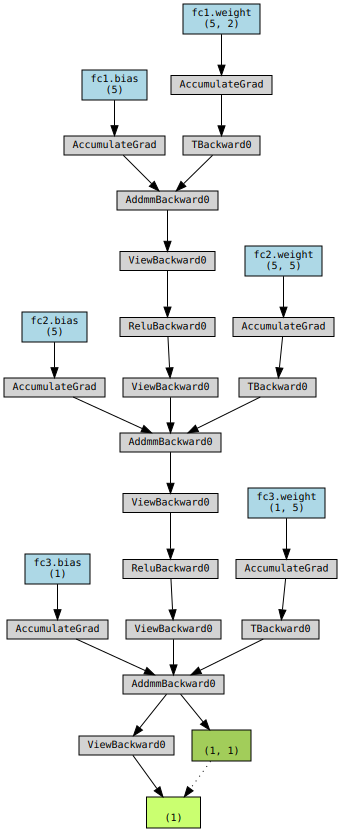

In [20]:
# Let's take a look at our network
make_dot(tinyNet(Input[0]),params=dict(list(tinyNet.named_parameters())))

In [21]:
# Use tensor board to visualize network
# Launch Tensorboard
# Observe graph structure of our network

writer = SummaryWriter("./logs/")
writer.add_graph(tinyNet,Input)
writer.close()

In [22]:
writer.add_graph(simpleNet,Input)
writer.close()

Next step in training a neural network is to perform back propagation.
Automatic gradient calculations in python help quickly perform
chained derivatives in one shot.

In [23]:
# Let's do one backward pass
# Recall automatic differentiation of pytorch, all the gradients are calculated in one shot

loss.backward()

In [24]:
# Next step in the training process is to update the weights
# Choose a gradient update rule
# SGD, Nesterov-SGD, Adam or RMSProp etc. Please find a list of algorithms at 
# https://pytorch.org/docs/stable/optim.html#algorithms
# And learning rate, momentum


# Define san optimizer, here we are looking at SGD
optimizer=optim.SGD(tinyNet.parameters(),lr=0.01,momentum=.9)

In [25]:
# Let's create a very naive training loop
loss_trace=[]
for i in range(K):
    eval_loss=[]
    optimizer.zero_grad() # zero the past gradients
    predict=tinyNet(Input[i]) # perform forward pass
    loss=loss_metric(Output[i],predict) # calculate loss
    loss.backward() # perform gradient descent
    optimizer.step() # update weights

    # Loop through all the past samples to estimate mean loss
    if i:
        eval_loss=[loss_metric(Output[j],tinyNet(Input[j])).item() for j in range(K)]
        loss_trace.append(np.mean(eval_loss))


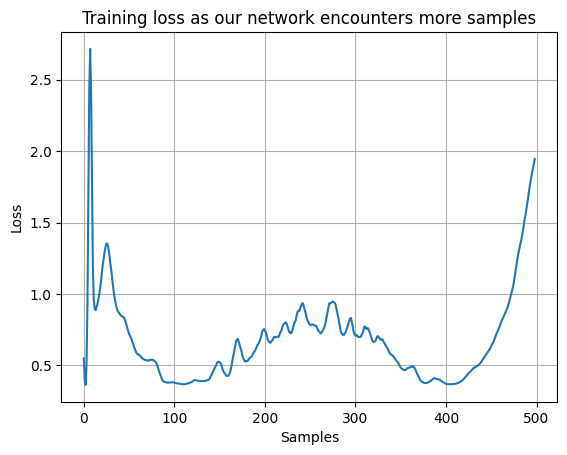

In [26]:
## plot loss 
plt.plot(loss_trace)
plt.title("Training loss as our network encounters more samples")
plt.ylabel("Loss")
plt.xlabel("Samples")
plt.grid()
# This is a dummy plot and may not of any use


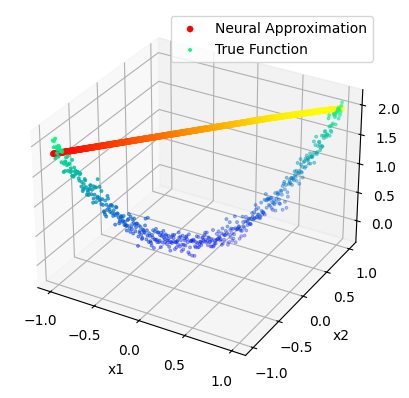

In [26]:
f_predict=tinyNet(Input)
Q_function_learnt=f_predict.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function_learnt, c=Q_function_learnt, marker="o", cmap='autumn', label="Neural Approximation", linewidth=.25)
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',label="True Function", marker='.', linewidth=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.legend()

In [27]:
# Calculate test loss
test_loss=[loss_metric(Output_test[j],tinyNet(Input_test[j])).item() for j in range(T)]


Network is yet to learn our function. With our available training data, we train the network in cycles, called epochs

In [28]:
# Learning algorithms are trained in epochs or episodes
# Our previous training loop forms one epoch
# Where we iterated through all our data once and we looked at training performance

# learning in epochs

num_epochs=50
tinyNetStack=smallNetStack().to(device) # create model instance

optimizer=optim.SGD(tinyNetStack.parameters(),lr=0.01,momentum=.9)
tinyNetStack_loss_trace=[]
tinyNetStack_testloss_trace=[]
for epoch in range(num_epochs):
    train_loss=[]
    test_loss=[]
    for i in range(K):
        optimizer.zero_grad() # zeros the past gradient 
        predict=tinyNetStack(Input[i]) # forward pass
        loss=loss_metric(Output[i],predict) # calculate loss
        loss.backward() # performs gradient descent for the entire network
        optimizer.step() # updates weights
        
    train_loss=[loss_metric(Output[j],tinyNetStack(Input[j])).item() for j in range(K)]
    test_loss=[loss_metric(Output_test[j],tinyNetStack(Input_test[j])).item() for j in range(T)]        
    tinyNetStack_loss_trace.append(np.mean(train_loss))
    tinyNetStack_testloss_trace.append(np.mean(test_loss))

In [29]:
tinyNetStack_testloss_trace=[loss_metric(Output_test[j],tinyNet(Input_test[j])).item() for j in range(T)]

[2, 2, 4, 4, 1, 1]
Total number of parameters in the network 14


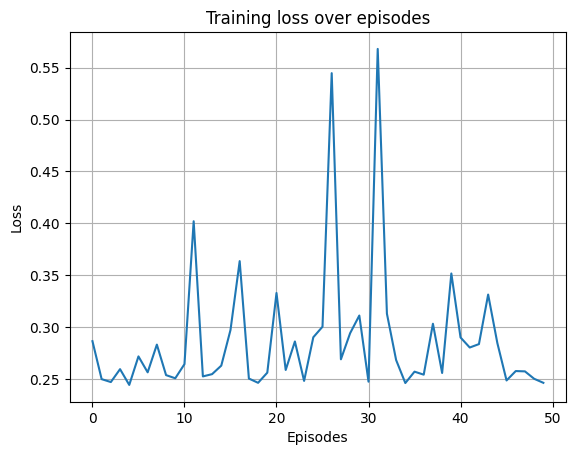

In [30]:
## plot loss 
plt.plot(tinyNetStack_loss_trace)
plt.title("Training loss over episodes")
plt.ylabel("Loss")
plt.xlabel("Episodes")
plt.grid()
#print("Converge Loss: Tiny Net,",tinyNetStack_loss_trace[20])
Model_Training_Performance.append(tinyNetStack_loss_trace[num_epochs-1])
Model_Testing_Performance.append(tinyNetStack_loss_trace[num_epochs-1])
Model_Parameters.append(parameters(tinyNetStack))

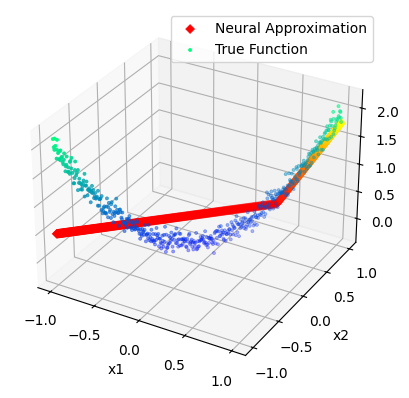

In [31]:
f_predict=tinyNetStack(Input)
Q_function_learnt=f_predict.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function_learnt, c=Q_function_learnt, marker="D", cmap='autumn', label="Neural Approximation", linewidth=.5)
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',label="True Function", marker='.', linewidth=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.legend()

Some thoughtful explorations:
1. Why do we need to randomize inputs
2. What happens if we don't 

In [32]:
# let's write a function that takes num_of_epochs, input, target as arguments
# returns loss

def training_network(num_epochs,model,input,target):
    """ 
     function to train a neural network
    """
    epoch_loss_trace=[]
    epoch_testloss_trace=[]
    # resets all the model weights, to avoid errors in the observation
    # unless we reset the weights, model still remains in the memory
    for layer in model.children():
         if hasattr(layer,"reset_parameters"):
             layer.reset_parameters()
    # define optimizer
    loss_fn=nn.MSELoss()
    optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(num_epochs):   
        loss_accumulation=0
        testloss_accumulation=0
        for i in range(K):
            optimizer.zero_grad() # Clear the past gradients to make gradients zero
            predict=model(Input[i]) # Forward pass
            loss=loss_fn(Output[i],predict) # Calculates loss
            loss_accumulation+=loss.item() # Stores loss
            loss.backward() # performs gradient descent
            optimizer.step() # updates weights
        epoch_loss_trace.append(loss_accumulation/len(input))
        testloss_accumulation=[loss_fn(Output_test[j],model(Input_test[j])).item() for j in range(T)]
        epoch_testloss_trace.append(np.mean(testloss_accumulation))
        scheduler.step() # schedules learning rate
    return epoch_loss_trace,epoch_testloss_trace

In [33]:
def plot_loss(train_loss,test_loss,num_params):
    """
    function to test loss
    """
    fig,(ax1,ax2)=plt.subplots(2, figsize=(8, 8))
    ax1.plot(train_loss)
    ax1.set_title(f"Training loss over episodes, Parameters {num_params}")
    ax1.set_ylabel("Loss")
    #ax1.set_xlabel("Episodes")
    ax1.grid()
    ax2.plot(test_loss)
    ax2.set_title(f"Test loss over episodes, Parameters {num_params}")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

In [34]:
parameters(simpleNet)

[1, 1, 1, 1]
Total number of parameters in the network 4


4

In [35]:
simpleNet_loss_trace,simpleNet_testloss_trace=training_network(num_epochs,simpleNet,Input,Output)
Model_Training_Performance.insert(0,simpleNet_loss_trace[num_epochs-1])
Model_Testing_Performance.insert(0,simpleNet_testloss_trace[num_epochs-1])
Model_Parameters.insert(0,parameters(simpleNet))

[1, 1, 1, 1]
Total number of parameters in the network 4


[1, 1, 1, 1]
Total number of parameters in the network 4


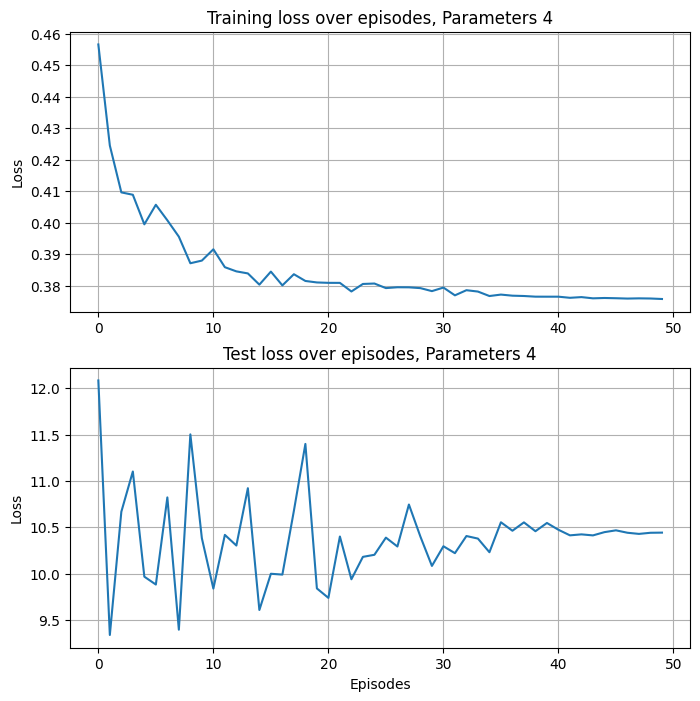

In [36]:
plot_loss(simpleNet_loss_trace,simpleNet_testloss_trace,parameters(simpleNet))

In [37]:
# Let's create a network with more parameters
class mediumNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() # what's the use this
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(), 
        nn.Linear(100,100),
        nn.ReLU(),        # output and input of next fully connected must match
        nn.Linear(100,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat


In [38]:
mediumNet=mediumNetwork().to(device)

In [39]:
parameters(mediumNet)

[10, 10, 100, 100, 100, 100, 100, 100, 1, 1]
Total number of parameters in the network 622


622

In [40]:
mediumNet_loss_trace,mediumNet_testloss_trace=training_network(num_epochs,mediumNet,Input,Output)
Model_Training_Performance.append(mediumNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(mediumNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(mediumNet))


[10, 10, 100, 100, 100, 100, 100, 100, 1, 1]
Total number of parameters in the network 622


[10, 10, 100, 100, 100, 100, 100, 100, 1, 1]
Total number of parameters in the network 622


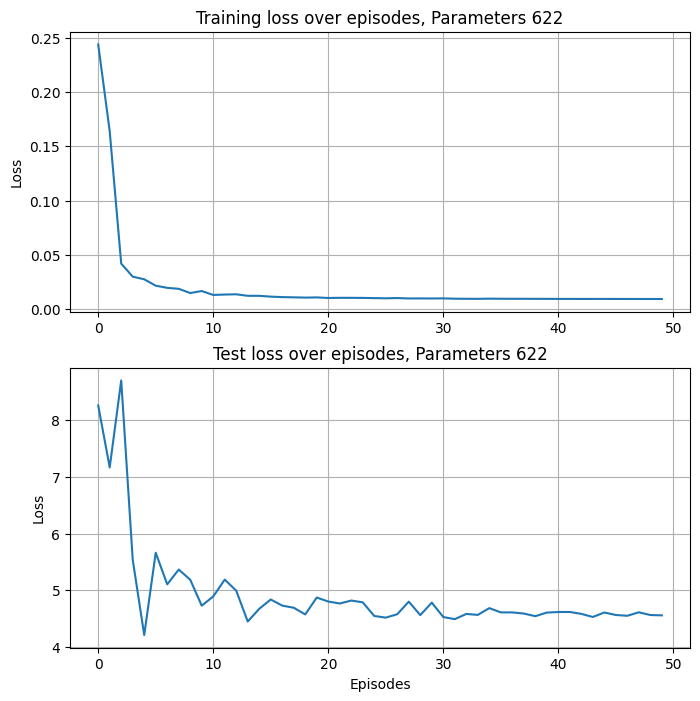

In [41]:
plot_loss(mediumNet_loss_trace,mediumNet_testloss_trace,parameters(mediumNet))

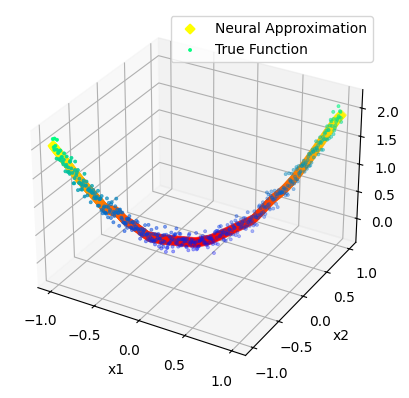

In [42]:
f_predict=mediumNet(Input)
Q_function_learnt=f_predict.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function_learnt, c=Q_function_learnt, marker="D", cmap='autumn', label="Neural Approximation", linewidth=1.5)
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',label="True Function", marker='.', linewidth=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.legend()

In [43]:
class largeNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10,100),
        nn.ReLU(),
        nn.Linear(100,200),
        nn.ReLU(), 
        nn.Linear(200,300),
        nn.ReLU(),
        nn.Linear(300,10),
        nn.ReLU(),                   
        nn.Linear(10,1)) 
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat

In [44]:
largeNet=largeNetwork().to(device)

In [45]:
parameters(largeNet)

[10, 10, 100, 100, 200, 200, 300, 300, 10, 10, 1, 1]
Total number of parameters in the network 1242


1242

In [47]:
largeNet_loss_trace,largeNet_testloss_trace=training_network(num_epochs,largeNet,Input,Output)
Model_Training_Performance.append(largeNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(largeNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(largeNet))



[10, 10, 100, 100, 200, 200, 300, 300, 10, 10, 1, 1]
Total number of parameters in the network 1242


[10, 10, 100, 100, 200, 200, 300, 300, 10, 10, 1, 1]
Total number of parameters in the network 1242


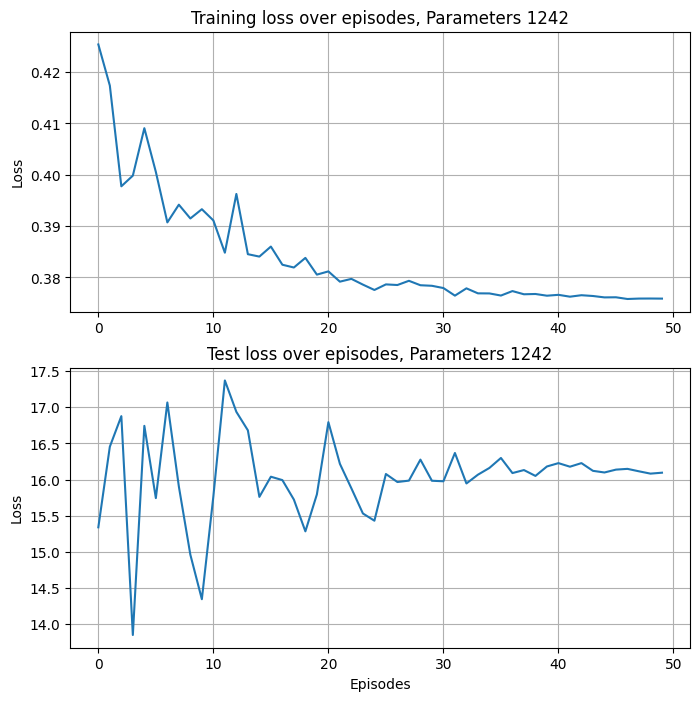

In [48]:
plot_loss(largeNet_loss_trace,largeNet_testloss_trace,parameters(largeNet))

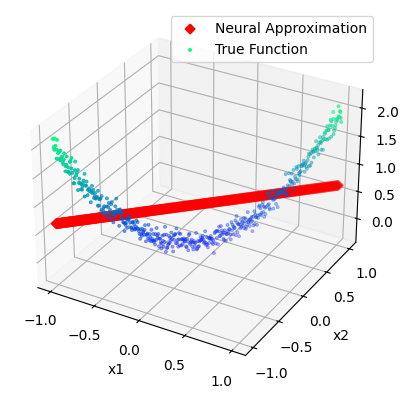

In [49]:
f_predict=largeNet(Input)
Q_function_learnt=f_predict.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function_learnt, c=Q_function_learnt, marker="D", cmap='autumn', label="Neural Approximation", linewidth=1.5)
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',label="True Function", marker='.',linewidth=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.legend()

In [50]:
class largerNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() # what's the use this
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(2,100),
        nn.ReLU(),
        nn.Linear(100,9000),
        nn.ReLU(),
        nn.Linear(9000,15000),
        nn.ReLU(), 
        nn.Linear(15000,15000),
        nn.ReLU(),
        nn.Linear(15000,500),
        nn.ReLU(),                   # output and input of next fully connected must match
        nn.Linear(500,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat

In [51]:
largerNet=largerNetwork().to(device)

In [52]:
parameters(largerNet)

[100, 100, 9000, 9000, 15000, 15000, 15000, 15000, 500, 500, 1, 1]
Total number of parameters in the network 79202


79202

In [54]:
num_epochs=50

In [55]:
largerNet_loss_trace,largerNet_testloss_trace=training_network(num_epochs,largerNet,Input,Output)
Model_Training_Performance.append(largerNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(largerNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(largerNet))


[100, 100, 9000, 9000, 15000, 15000, 15000, 15000, 500, 500, 1, 1]
Total number of parameters in the network 79202


[100, 100, 9000, 9000, 15000, 15000, 15000, 15000, 500, 500, 1, 1]
Total number of parameters in the network 79202


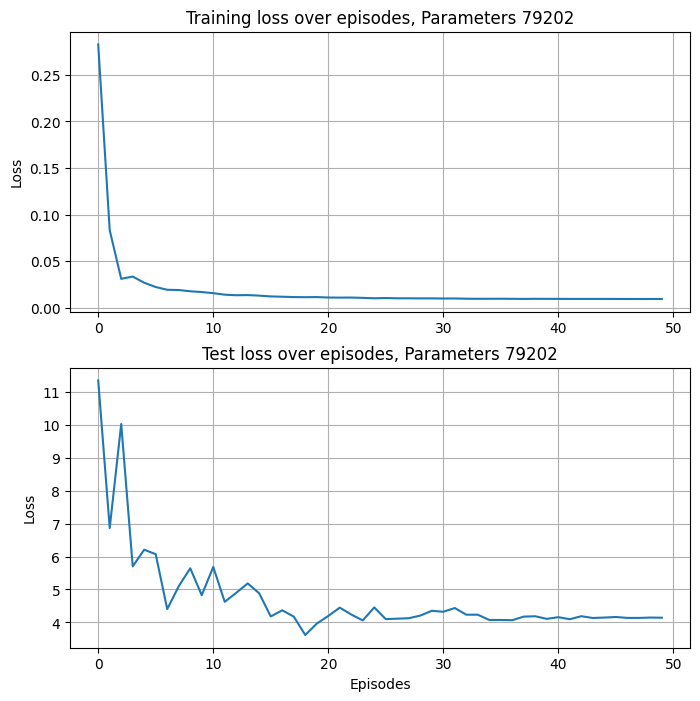

In [56]:
plot_loss(largerNet_loss_trace,largerNet_testloss_trace,parameters(largerNet))

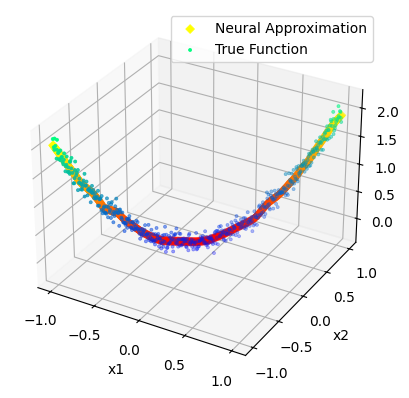

In [57]:
f_predict=largerNet(Input)
Q_function_learnt=f_predict.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Q_function_learnt, c=Q_function_learnt, marker="D", cmap='autumn', label="Neural Approximation", linewidth=.5)
ax.scatter(X1, X2, Q_function, c=Q_function, cmap='winter',label="True Function", marker='.', linewidth=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f')
ax.legend()

1. Change size of the dataset
2. Write your own neural networks architectures
3. See if you can observe deep neural double descent


Since, we are moving data to and fro cuda device, restart kernel if you face any memory issues.
Alteratively, you can check the gpu usage using the code below and check if you ran out of memory.

In case of memory problems, please restart the kernel. If you face cuda memory issues, run one cell at a time and store plots.

In [ ]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()                             
torch.cuda.empty_cache()
gpu_usage() 

In [57]:
# use this test network to explore double descent parameters
class test(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(2,50),
        
        nn.ReLU(),
        nn.Linear(50,15),
        nn.ReLU(),                   # output and input of next fully connected must match
        nn.Linear(15,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat

In [58]:
testNet=test().to(device)

In [59]:
parameters(testNet)

[50, 50, 15, 15, 1, 1]
Total number of parameters in the network 132


132

In [60]:
num_epochs=50

Text(0.5, 0, 'Episodes')

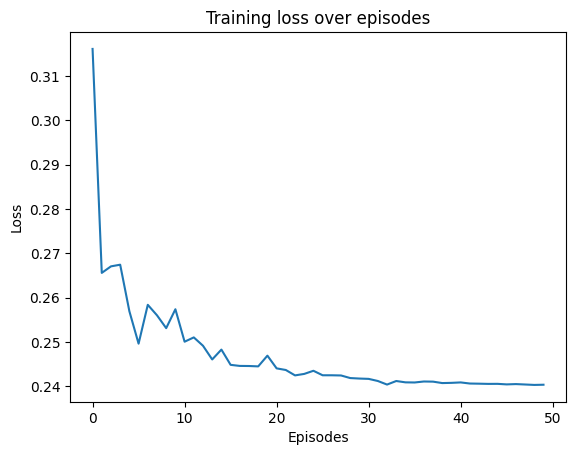

In [61]:
testNet_loss_trace,testNet_testloss_trace=training_network(num_epochs,testNet,Input,Output)

plt.plot(testNet_loss_trace)
plt.title("Training loss over episodes")
plt.ylabel("Loss")
plt.xlabel("Episodes")

[50, 50, 15, 15, 1, 1]
Total number of parameters in the network 132


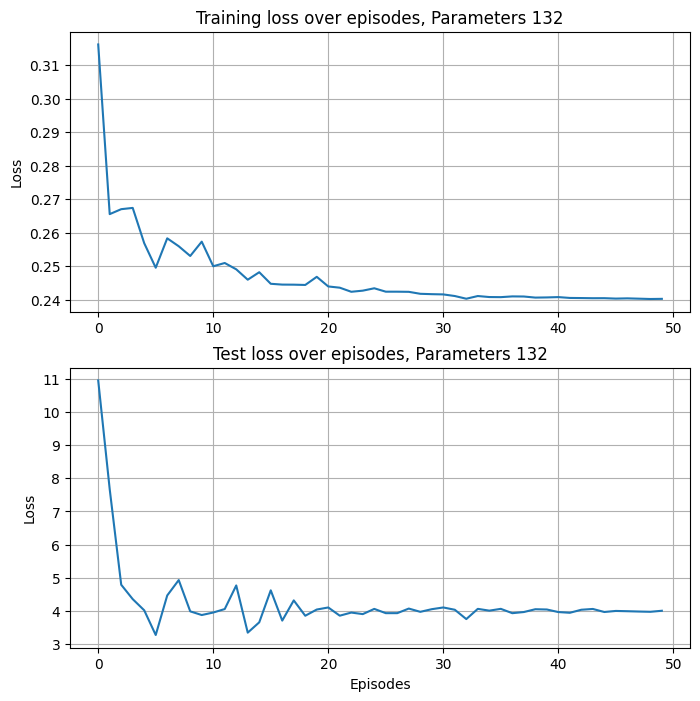

In [62]:
plot_loss(testNet_loss_trace,testNet_testloss_trace,parameters(testNet))

In [63]:
Model_Testing_Performance.insert(2,testNet_testloss_trace[num_epochs-1])
Model_Parameters.insert(2,parameters(testNet))

[50, 50, 15, 15, 1, 1]
Total number of parameters in the network 132


In [64]:
del Model_Parameters[-2]
del Model_Testing_Performance[-2]

<bound method _AxesBase.grid of <Axes: title={'center': 'Double Descent of Neural Networks'}, xlabel='Parameters', ylabel='Testing Loss'>>

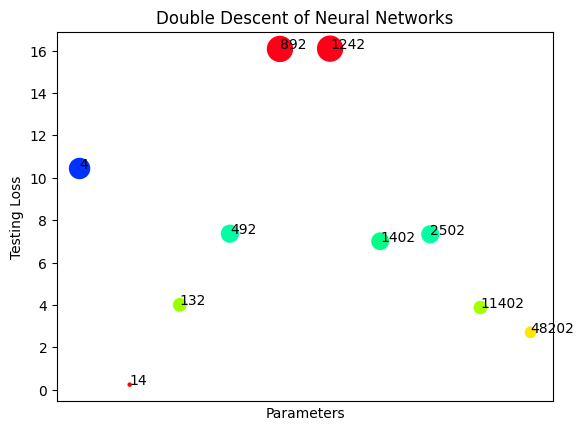

In [65]:
# Double Descent
fig,ax=plt.subplots()
colors=Model_Testing_Performance
ax.scatter(np.arange(len(Model_Testing_Performance)),Model_Testing_Performance,c=colors,cmap='hsv',s=np.dot(20,Model_Testing_Performance))
for i in range(len(Model_Parameters)):
    ax.annotate(Model_Parameters[i],(i,Model_Testing_Performance[i]))
ax.set_title("Double Descent of Neural Networks")
ax.set_ylabel("Testing Loss")
ax.set_xlabel("Parameters")
ax.set_xticks([])
ax.grid